# 🎵 Music Genre Classification - EDA & Model Training

## Project Overview

This notebook provides a comprehensive analysis of the **GTZAN Dataset** for music genre classification. We'll cover:

1. **How Audio Becomes Data** - Understanding feature extraction from audio signals
2. **Exploratory Data Analysis (EDA)** - Visualizing audio characteristics and feature distributions
3. **Model Selection** - Comparing multiple ML algorithms with cross-validation
4. **Hyperparameter Tuning** - GridSearchCV for optimal model performance
5. **Evaluation** - Confusion matrices, classification reports, and error analysis

### The GTZAN Dataset
- **1000 audio tracks** (30 seconds each)
- **10 genres**: Blues, Classical, Country, Disco, Hip-hop, Jazz, Metal, Pop, Reggae, Rock
- **100 tracks per genre** (balanced dataset)
- **Pre-extracted features**: 57 audio features per track

---

## 1. Import Required Libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Model persistence
import joblib
import pickle

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ All libraries imported successfully!")
print(f"Librosa version: {librosa.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")

✅ All libraries imported successfully!
Librosa version: 0.11.0
Scikit-learn version: 1.8.0


## 2. Load and Explore the Dataset

In [2]:
# Define paths - adjust if running from different location
# If running from notebooks folder:
BASE_DIR = os.path.dirname(os.getcwd()) if 'notebooks' in os.getcwd() else os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
ARTIFACTS_DIR = os.path.join(BASE_DIR, 'artifacts')

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")

# Load the 30-second features dataset
df = pd.read_csv(os.path.join(DATA_DIR, 'features_30_sec.csv'))

print(f"\n📊 Dataset Shape: {df.shape}")
print(f"\n📁 Columns ({len(df.columns)}):")
print(df.columns.tolist())

df.head()

Base directory: c:\Users\sophi\Desktop\Ynov\Cours\Concepts_technos_IA\MLDeploy
Data directory: c:\Users\sophi\Desktop\Ynov\Cours\Concepts_technos_IA\MLDeploy\data

📊 Dataset Shape: (999, 60)

📁 Columns (60):
['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661500,0.349951,0.088752,0.130192,0.002830,1784.416546,129739.837273,2002.657106,85829.345949,...,52.464138,-1.688358,36.564606,-0.409328,41.643627,-2.298869,55.076687,1.219947,46.975636,blues
1,blues.00001.wav,661500,0.340945,0.094968,0.095892,0.002374,1529.871314,376011.650353,2038.612143,213889.874085,...,55.364292,-0.717028,60.113293,0.292333,48.137737,-0.285717,51.131210,0.532144,45.823231,blues
2,blues.00002.wav,661500,0.363562,0.085277,0.175494,0.002753,1552.637786,156538.294605,1747.382028,76150.688723,...,40.620197,-7.721793,47.700275,-1.816497,52.418175,-3.434354,46.630066,-2.231391,30.626228,blues
3,blues.00003.wav,661500,0.404848,0.094018,0.141139,0.006340,1070.110059,184506.655476,1596.244204,166637.568358,...,44.456993,-3.320055,50.236969,0.637263,37.351917,-0.617507,37.291164,-3.406940,31.988438,blues
4,blues.00004.wav,661500,0.308598,0.087850,0.091540,0.002305,1835.507008,343334.237032,1748.367477,88460.061216,...,86.012779,-5.453736,75.328178,-0.924468,53.577564,-4.408076,62.928513,-11.701833,55.215122,blues


In [3]:
# Basic dataset info
print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)

print(f"\n📊 Shape: {df.shape[0]} samples x {df.shape[1]} features")
print(f"\n🎵 Genres: {df['label'].nunique()}")
print(df['label'].unique())

print(f"\n📈 Data Types:")
print(df.dtypes.value_counts())

print(f"\n❌ Missing Values:")
missing = df.isnull().sum().sum()
print(f"Total missing values: {missing}")

print(f"\n📉 Basic Statistics:")
df.describe()

DATASET INFORMATION

📊 Shape: 999 samples x 60 features

🎵 Genres: 10
<StringArray>
[    'blues', 'classical',   'country',     'disco',    'hiphop',      'jazz',
     'metal',       'pop',    'reggae',      'rock']
Length: 10, dtype: str

📈 Data Types:
float64    57
str         2
int64       1
Name: count, dtype: int64

❌ Missing Values:
Total missing values: 0

📉 Basic Statistics:


,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,661497.325325,0.378797,0.086348,0.130843,0.003051,2202.441329,4.698182e+05,2242.748051,136968.887480,4572.989219,...,1.150250,60.719009,-3.967345,62.613336,0.509079,63.696639,-2.329195,66.230190,-1.094665,70.069847
std,49.988428,0.081683,0.007745,0.065684,0.003637,716.096608,4.009062e+05,526.560412,96485.722577,1575.083232,...,4.581225,33.788525,4.552783,33.487309,3.871133,34.413580,3.757358,37.206801,3.839568,45.242018
min,660000.000000,0.171770,0.044578,0.005270,0.000004,570.150688,7.957773e+03,899.979779,11160.012397,749.528801,...,-15.697483,9.205503,-17.235107,13.846979,-11.985029,15.395741,-18.505476,13.382763,-19.933723,7.877424
25%,661500.000000,0.319611,0.082318,0.086536,0.000940,1626.610837,1.846052e+05,1906.844369,67303.271096,3380.521225,...,-1.857121,40.308216,-7.202209,40.792536,-2.008568,41.836611,-4.676660,41.729815,-3.366760,42.307158
50%,661500.000000,0.383123,0.086617,0.122231,0.001822,2209.573799,3.390061e+05,2221.382901,111923.518392,4659.646824,...,1.230336,52.277477,-4.063002,54.749981,0.669362,54.820686,-2.388752,57.369091,-1.141452,59.121056
75%,661500.000000,0.435704,0.091260,0.175749,0.003584,2692.954240,6.130300e+05,2578.954341,182238.560978,5534.520700,...,4.350543,71.428036,-0.843441,74.895702,3.113753,75.498482,0.154173,78.574417,1.308530,85.197460
max,661500.000000,0.663541,0.108048,0.397851,0.027708,4434.948743,3.035514e+06,3509.582338,695146.000568,8676.447535,...,13.479482,393.224304,11.479182,405.858307,15.386705,332.277771,14.691521,393.676514,15.362202,505.779510


## 3. Exploratory Data Analysis (EDA)

### 3.1 Class Distribution
A balanced dataset is crucial for classification. Let's verify the genre distribution.

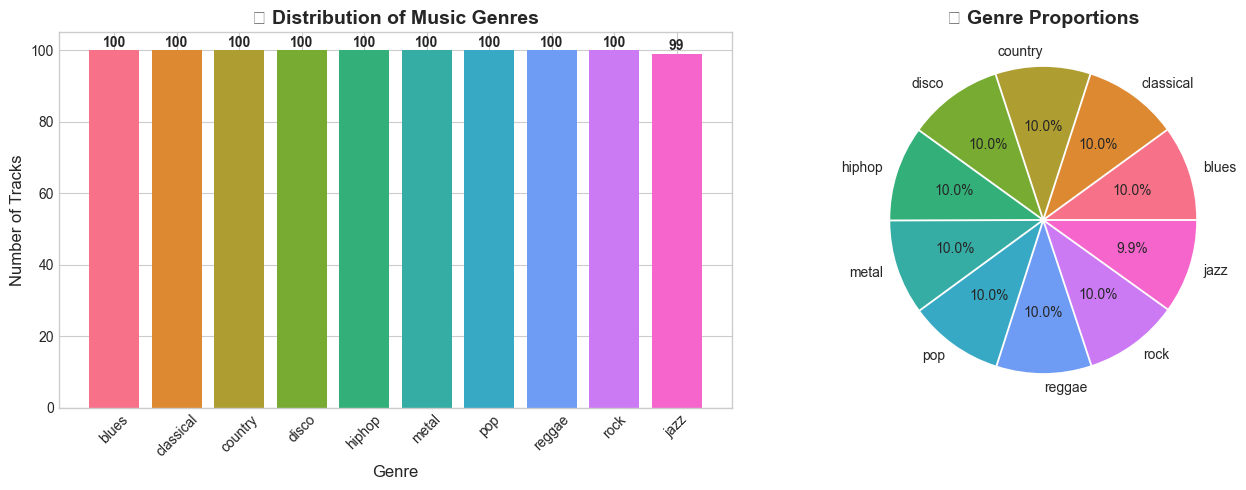


✅ Dataset is perfectly balanced: 100 samples per genre


In [4]:
# Genre distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
genre_counts = df['label'].value_counts()
colors = sns.color_palette('husl', n_colors=10)
axes[0].bar(genre_counts.index, genre_counts.values, color=colors)
axes[0].set_xlabel('Genre', fontsize=12)
axes[0].set_ylabel('Number of Tracks', fontsize=12)
axes[0].set_title('🎵 Distribution of Music Genres', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(genre_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', 
            colors=colors, explode=[0.02]*10)
axes[1].set_title('🎵 Genre Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Dataset is perfectly balanced: {genre_counts.values[0]} samples per genre")

### 3.2 How Audio Becomes Data - Feature Extraction Explained

Audio signals are transformed into numerical features that machine learning models can process. Here's how:

#### Key Audio Features:

| Feature | Description | Why It Matters |
|---------|-------------|----------------|
| **MFCCs** (Mel-Frequency Cepstral Coefficients) | Represents the short-term power spectrum | Captures timbral texture, most important for genre |
| **Spectral Centroid** | "Center of mass" of the spectrum | Indicates brightness of sound |
| **Spectral Bandwidth** | Width of the spectrum | Measures frequency spread |
| **Spectral Rolloff** | Frequency below which 85% of energy is contained | Distinguishes harmonic vs noisy sounds |
| **Zero Crossing Rate** | Rate of sign changes in the signal | Higher for percussive, noisy sounds |
| **Chroma Features** | Energy distribution across 12 pitch classes | Captures harmonic/melodic content |
| **RMS Energy** | Root mean square energy | Measures loudness |
| **Tempo** | Beats per minute | Rhythm characteristic |

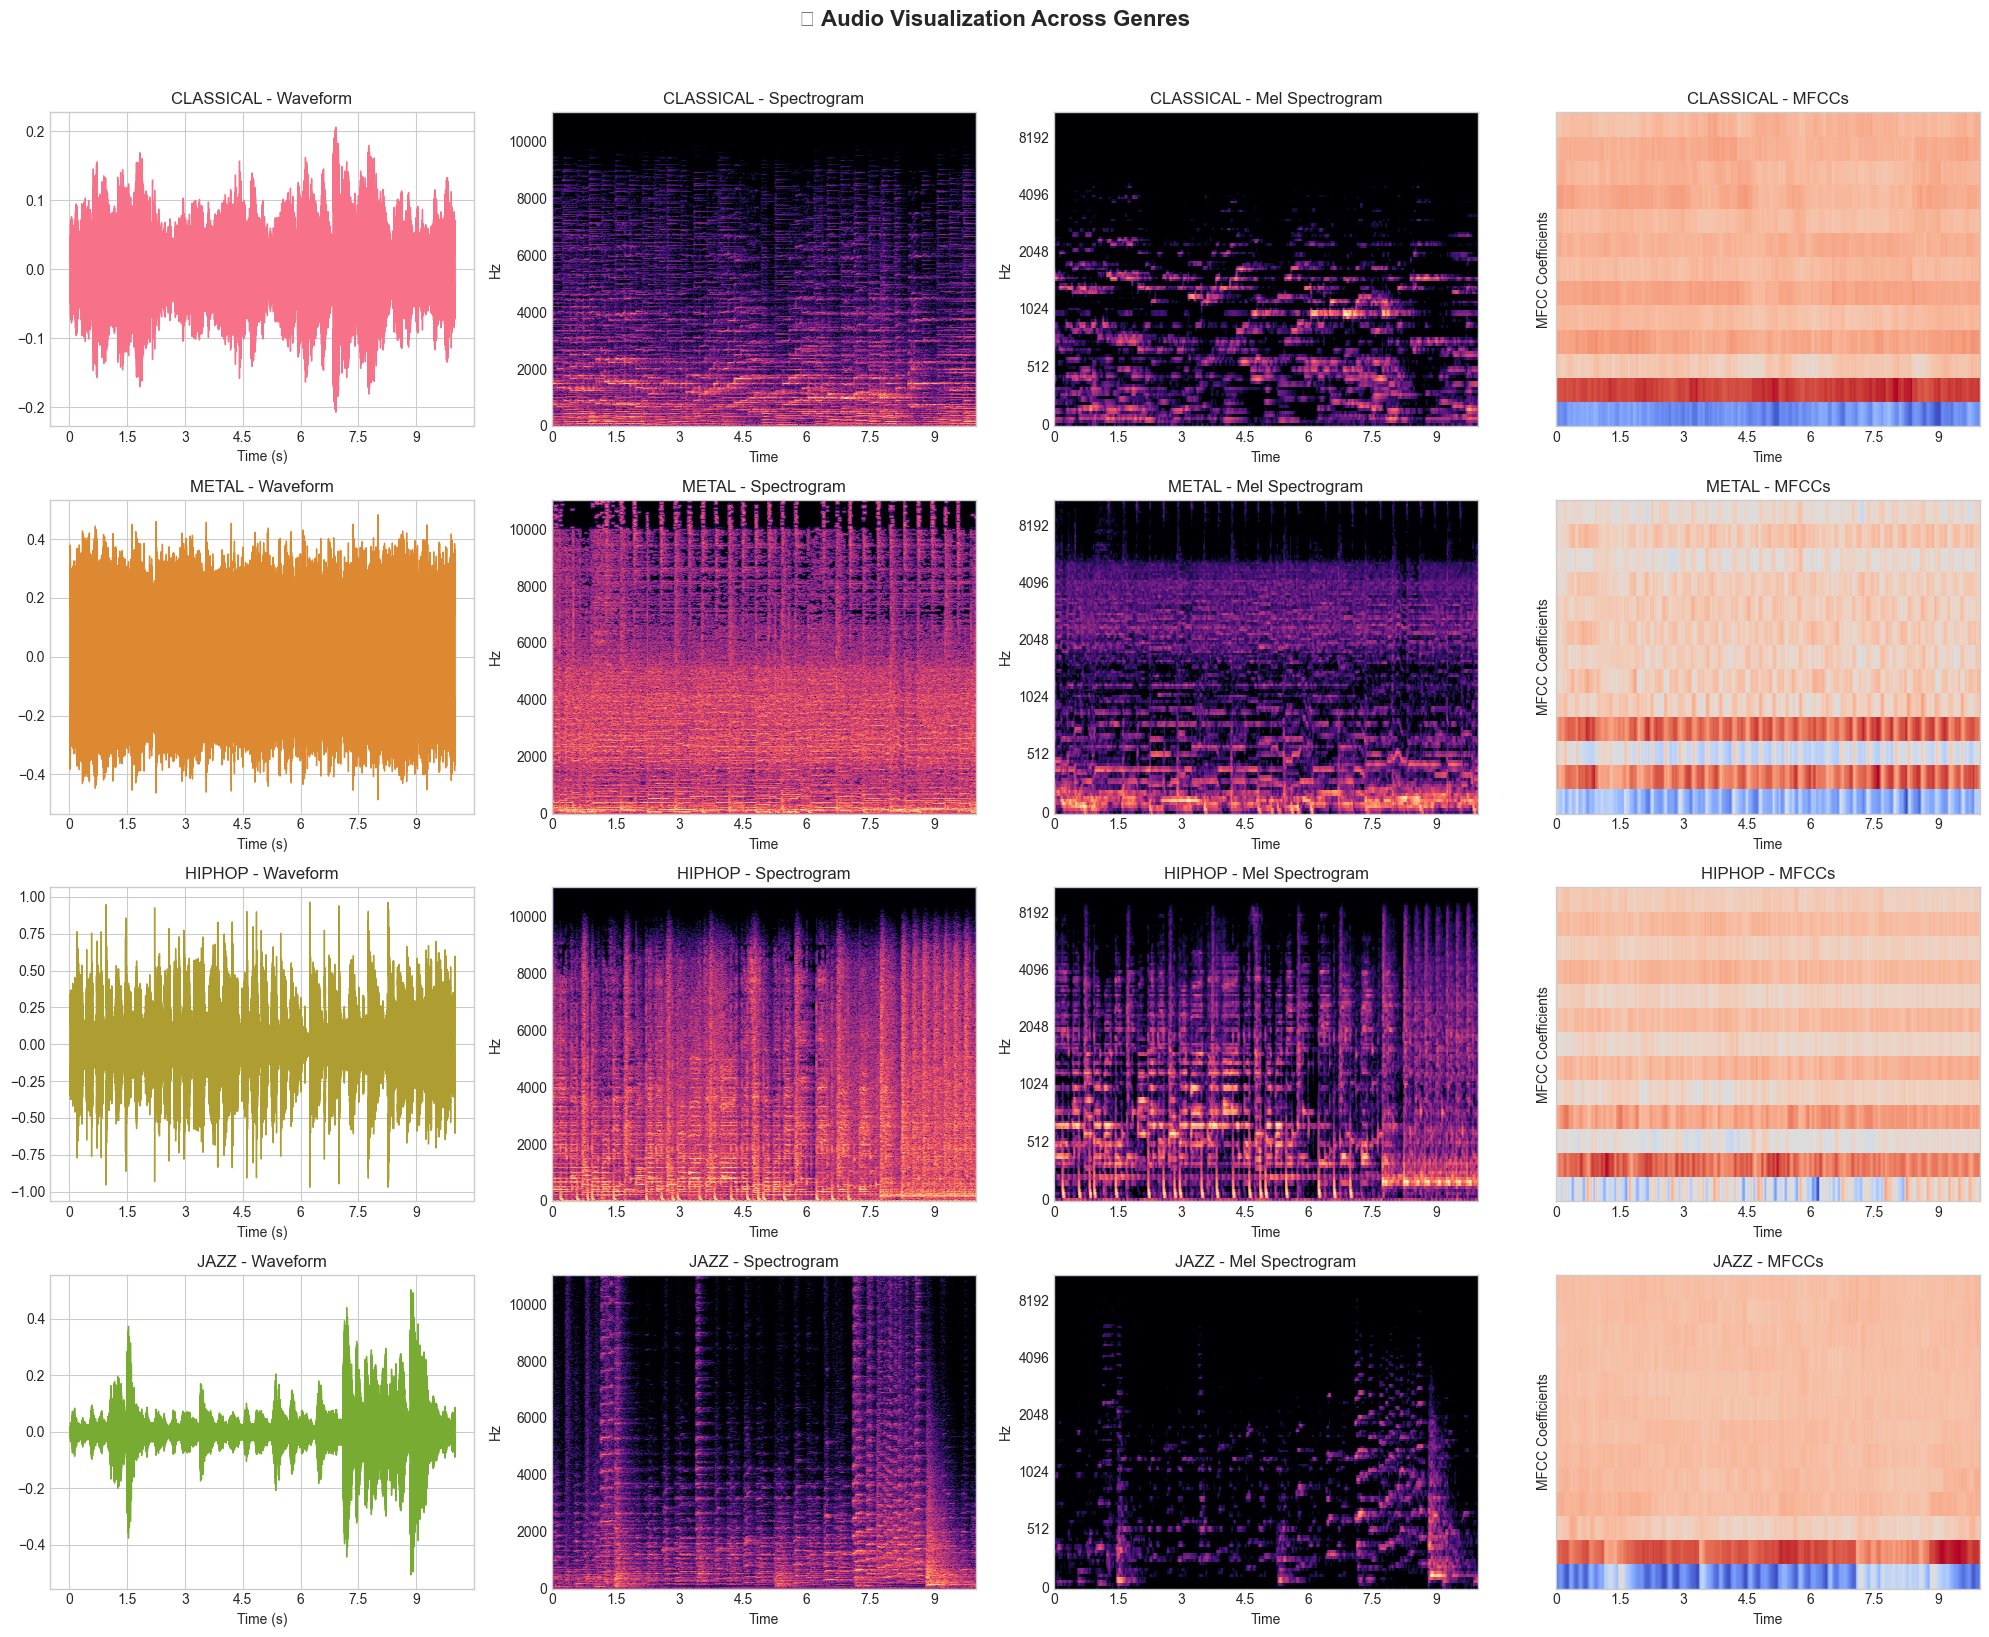


📊 Notice how different genres have distinct visual patterns:
  • Classical: Smooth waveforms, concentrated low frequencies
  • Metal: High amplitude, broad frequency spectrum
  • Hip-hop: Strong beats, rhythmic patterns
  • Jazz: Complex harmonic content, varied dynamics


In [5]:
# Visualize audio features from a sample track
sample_genres = ['classical', 'metal', 'hiphop', 'jazz']
audio_dir = os.path.join(DATA_DIR, 'genres_original')

# Check if audio files exist
if os.path.exists(audio_dir):
    fig, axes = plt.subplots(len(sample_genres), 4, figsize=(20, 4*len(sample_genres)))
    fig.suptitle('🎵 Audio Visualization Across Genres', fontsize=16, fontweight='bold', y=1.02)

    for i, genre in enumerate(sample_genres):
        genre_dir = os.path.join(audio_dir, genre)
        if os.path.exists(genre_dir):
            audio_files = [f for f in os.listdir(genre_dir) if f.endswith('.wav')]
            if audio_files:
                audio_path = os.path.join(genre_dir, audio_files[0])
                y, sr = librosa.load(audio_path, duration=10)
                
                # 1. Waveform
                librosa.display.waveshow(y, sr=sr, ax=axes[i, 0], color=colors[i])
                axes[i, 0].set_title(f'{genre.upper()} - Waveform')
                axes[i, 0].set_xlabel('Time (s)')
                
                # 2. Spectrogram
                D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
                librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[i, 1])
                axes[i, 1].set_title(f'{genre.upper()} - Spectrogram')
                
                # 3. Mel Spectrogram
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
                mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
                librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[i, 2])
                axes[i, 2].set_title(f'{genre.upper()} - Mel Spectrogram')
                
                # 4. MFCCs
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                librosa.display.specshow(mfccs, x_axis='time', ax=axes[i, 3])
                axes[i, 3].set_title(f'{genre.upper()} - MFCCs')
                axes[i, 3].set_ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()
    
    print("\n📊 Notice how different genres have distinct visual patterns:")
    print("  • Classical: Smooth waveforms, concentrated low frequencies")
    print("  • Metal: High amplitude, broad frequency spectrum")
    print("  • Hip-hop: Strong beats, rhythmic patterns")
    print("  • Jazz: Complex harmonic content, varied dynamics")
else:
    print("⚠️ Audio files not found. Using pre-extracted features only.")
    print("   This is fine - we have all features in the CSV!")

### 3.3 Feature Distribution Analysis

Let's examine how key features are distributed across genres.

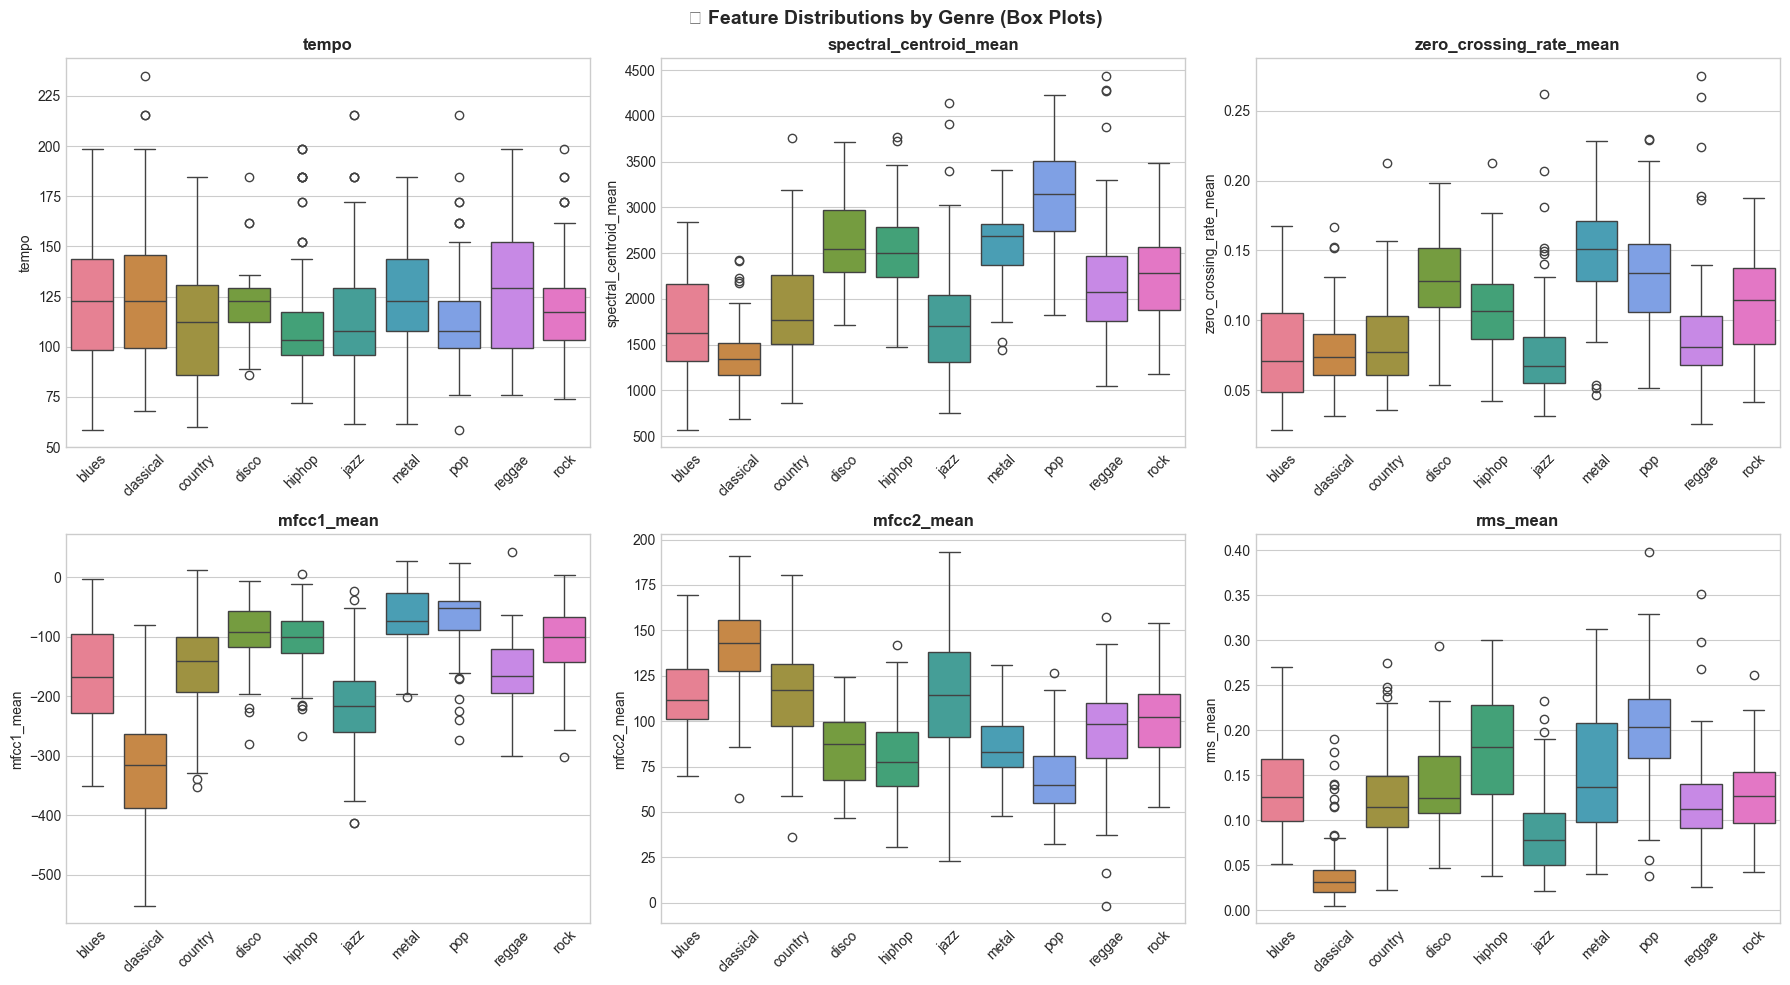


📊 Key Observations:
  • Tempo: Metal and Disco tend to have higher tempos
  • Spectral Centroid: Metal has higher values (brighter sound)
  • Zero Crossing Rate: Metal and Rock have higher ZCR (noisier)
  • MFCC values vary significantly across genres


In [6]:
# Box plots for key features by genre
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

features_boxplot = ['tempo', 'spectral_centroid_mean', 'zero_crossing_rate_mean', 
                    'mfcc1_mean', 'mfcc2_mean', 'rms_mean']

for idx, feature in enumerate(features_boxplot):
    sns.boxplot(data=df, x='label', y=feature, ax=axes[idx], palette='husl')
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_xlabel('')

plt.suptitle('🎵 Feature Distributions by Genre (Box Plots)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  • Tempo: Metal and Disco tend to have higher tempos")
print("  • Spectral Centroid: Metal has higher values (brighter sound)")
print("  • Zero Crossing Rate: Metal and Rock have higher ZCR (noisier)")
print("  • MFCC values vary significantly across genres")

### 3.4 Correlation Analysis

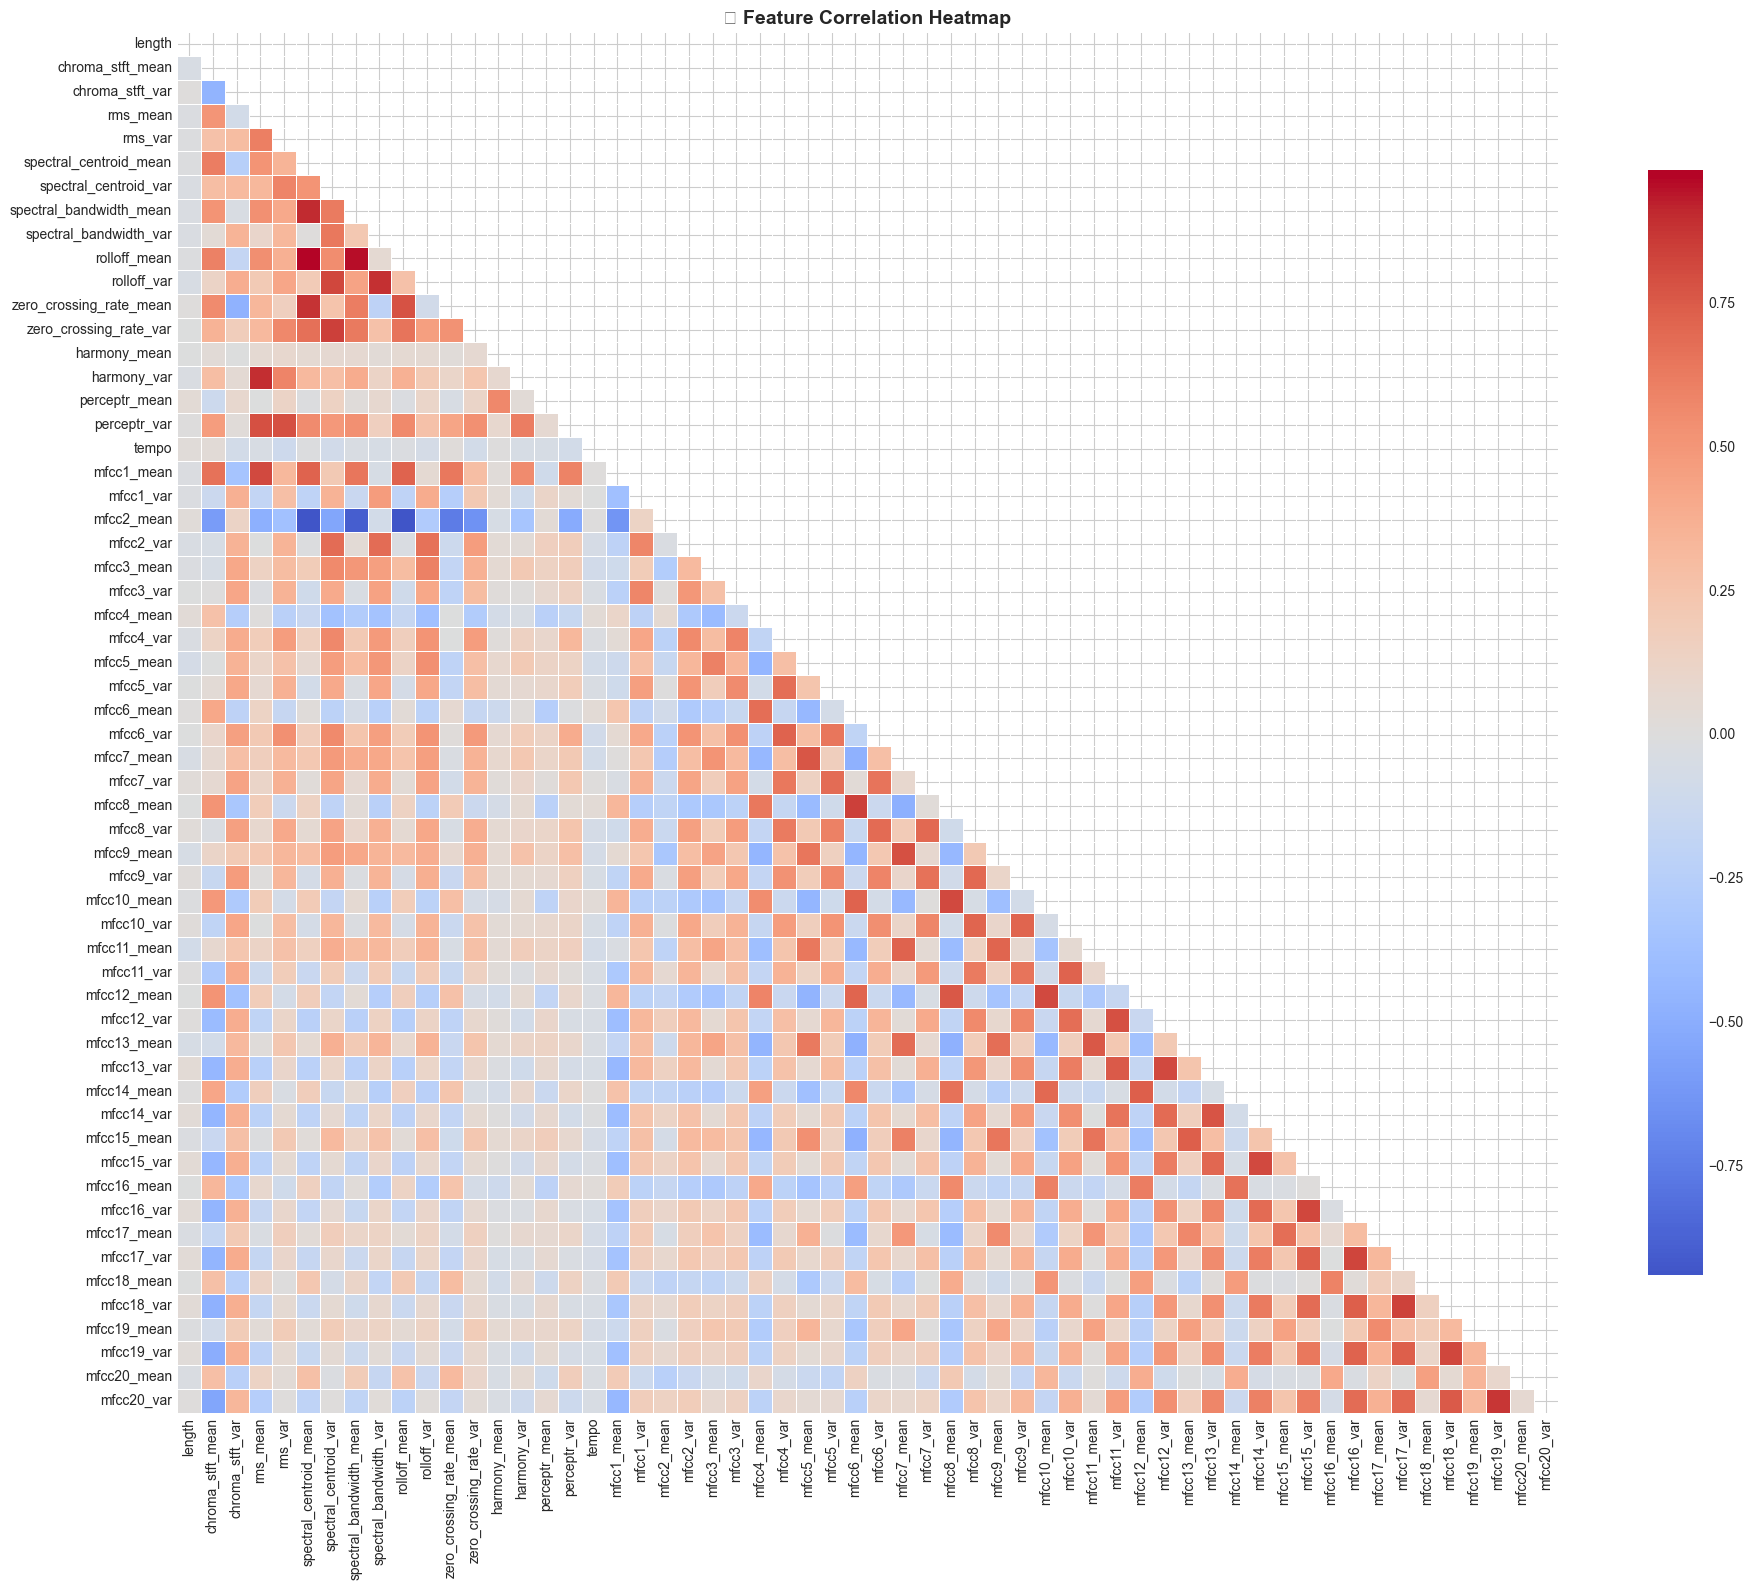


⚠️ Highly Correlated Features (|r| > 0.9): 5 pairs
  spectral_centroid_mean <-> spectral_bandwidth_mean: 0.905
  spectral_centroid_mean <-> rolloff_mean: 0.980
  spectral_centroid_mean <-> mfcc2_mean: -0.940
  spectral_bandwidth_mean <-> rolloff_mean: 0.956
  rolloff_mean <-> mfcc2_mean: -0.934


In [7]:
# Define feature columns (excluding filename and label)
feature_cols = [col for col in df.columns if col not in ['filename', 'label']]

# Correlation matrix
corr_matrix = df[feature_cols].corr()

# Plot heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('🔗 Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated features
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

print(f"\n⚠️ Highly Correlated Features (|r| > 0.9): {len(high_corr_pairs)} pairs")
for f1, f2, r in high_corr_pairs[:10]:
    print(f"  {f1} <-> {f2}: {r:.3f}")

### 3.5 Dimensionality Reduction Visualization (PCA & t-SNE)

Running t-SNE (this may take a moment)...


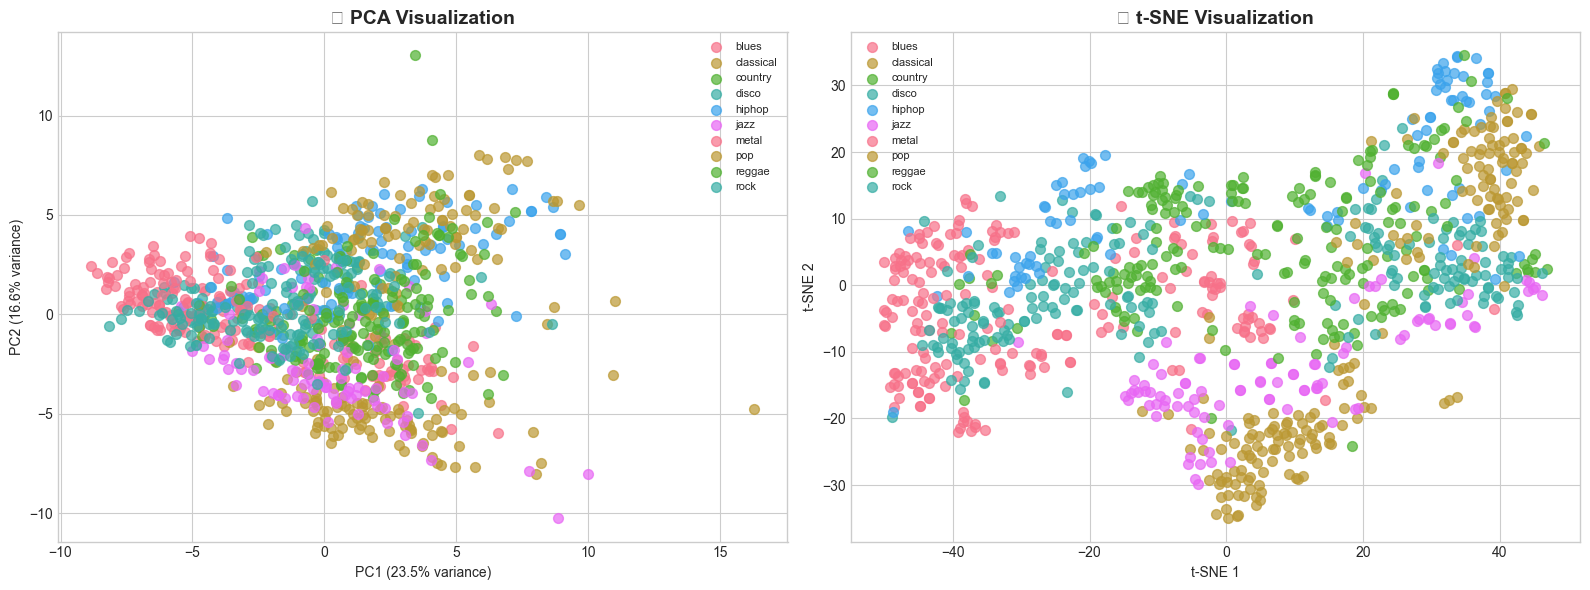


📊 PCA explains 40.2% of variance with 2 components

🔍 Observations:
  • Some genres form distinct clusters (Classical, Metal)
  • Others overlap significantly (Rock, Country, Pop)
  • This suggests some genres will be harder to classify


In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Prepare data
X = df[feature_cols].values
y = df['label'].values

# Scale features
scaler_viz = StandardScaler()
X_scaled = scaler_viz.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE
print("Running t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
for genre in np.unique(y):
    mask = y == genre
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], label=genre, alpha=0.7, s=50)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0].set_title('🎯 PCA Visualization', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=8)

# t-SNE plot
for genre in np.unique(y):
    mask = y == genre
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=genre, alpha=0.7, s=50)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('🎯 t-SNE Visualization', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\n📊 PCA explains {sum(pca.explained_variance_ratio_[:2])*100:.1f}% of variance with 2 components")
print("\n🔍 Observations:")
print("  • Some genres form distinct clusters (Classical, Metal)")
print("  • Others overlap significantly (Rock, Country, Pop)")
print("  • This suggests some genres will be harder to classify")

## 4. Data Preprocessing

### 4.1 Prepare Features and Labels

In [9]:
# Feature columns (57 features)
FEATURE_COLUMNS = [col for col in df.columns if col not in ['filename', 'label']]
print(f"Number of features: {len(FEATURE_COLUMNS)}")

# Extract features and labels
X = df[FEATURE_COLUMNS].values
y = df['label'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nGenres: {np.unique(y)}")

# Check for NaN or infinite values
print(f"\n❌ NaN values in X: {np.isnan(X).sum()}")
print(f"❌ Infinite values in X: {np.isinf(X).sum()}")

Number of features: 58

Feature matrix shape: (999, 58)
Labels shape: (999,)

Genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']

❌ NaN values in X: 0
❌ Infinite values in X: 0


### 4.2 Encode Labels and Scale Features

In [10]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label Encoding:")
for i, genre in enumerate(label_encoder.classes_):
    print(f"  {genre}: {i}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Features scaled (mean=0, std=1)")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"Sample scaled values: {X_scaled[0, :5]}")

# Save feature names for later
feature_names = FEATURE_COLUMNS

Label Encoding:
  blues: 0
  classical: 1
  country: 2
  disco: 3
  hiphop: 4
  jazz: 5
  metal: 6
  pop: 7
  reggae: 8
  rock: 9

✅ Features scaled (mean=0, std=1)
X_scaled shape: (999, 58)
Sample scaled values: [ 0.05353268 -0.35332613  0.31052643 -0.00991841 -0.06076703]


### 4.3 Train-Test Split

In [11]:
# Stratified split to maintain genre proportions
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # Important: maintain class distribution
)

print(f"📊 Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.0f}%)")
print(f"📊 Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.0f}%)")

# Verify stratification
print("\n✅ Class distribution in splits:")
train_dist = np.bincount(y_train) / len(y_train) * 100
test_dist = np.bincount(y_test) / len(y_test) * 100
for i, genre in enumerate(label_encoder.classes_):
    print(f"  {genre}: Train={train_dist[i]:.1f}%, Test={test_dist[i]:.1f}%")

📊 Training set: 799 samples (80%)
📊 Test set: 200 samples (20%)

✅ Class distribution in splits:
  blues: Train=10.0%, Test=10.0%
  classical: Train=10.0%, Test=10.0%
  country: Train=10.0%, Test=10.0%
  disco: Train=10.0%, Test=10.0%
  hiphop: Train=10.0%, Test=10.0%
  jazz: Train=9.9%, Test=10.0%
  metal: Train=10.0%, Test=10.0%
  pop: Train=10.0%, Test=10.0%
  reggae: Train=10.0%, Test=10.0%
  rock: Train=10.0%, Test=10.0%


## 5. Model Selection and Baseline Comparison

We'll compare multiple classification algorithms to find the best performer.

In [ ]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'MLP Neural Network': MLPClassifier(max_iter=1000, random_state=42)
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

print("🔄 Running 5-Fold Cross-Validation...")
print("=" * 60)

for name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    results.append({
        'Model': name,
        'Mean Accuracy': scores.mean(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max()
    })
    
    print(f"{name:25s} | Accuracy: {scores.mean():.4f} (±{scores.std():.4f})")

print("=" * 60)

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('Mean Accuracy', ascending=False)
results_df

🔄 Running 5-Fold Cross-Validation...
Logistic Regression       | Accuracy: 0.6922 (±0.0321)
K-Nearest Neighbors       | Accuracy: 0.6571 (±0.0250)
Support Vector Machine    | Accuracy: 0.7147 (±0.0285)
Random Forest             | Accuracy: 0.6872 (±0.0268)
Gradient Boosting         | Accuracy: 0.7122 (±0.0267)
MLP Neural Network        | Accuracy: 0.7222 (±0.0366)


,Model,Mean Accuracy,Std,Min,Max
5,MLP Neural Network,0.722186,0.036554,0.66250,0.768750
2,Support Vector Machine,0.714693,0.028506,0.66875,0.754717
4,Gradient Boosting,0.712186,0.026668,0.68125,0.748428
0,Logistic Regression,0.692162,0.032053,0.64375,0.729560
3,Random Forest,0.687162,0.026849,0.65625,0.729560
1,K-Nearest Neighbors,0.657131,0.025040,0.63125,0.704403


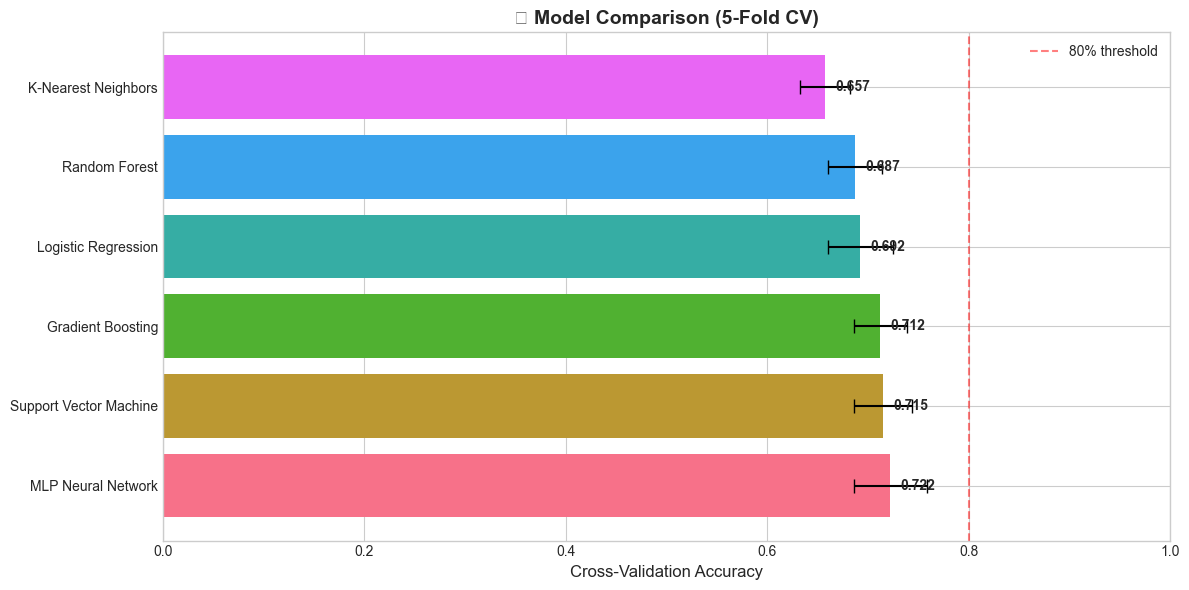


🏆 Best performing baseline model: MLP Neural Network
   Mean CV Accuracy: 0.7222


In [13]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette('husl', n_colors=len(results_df))
bars = ax.barh(results_df['Model'], results_df['Mean Accuracy'], 
               xerr=results_df['Std'], color=colors, capsize=5)

# Add accuracy values on bars
for i, (acc, std) in enumerate(zip(results_df['Mean Accuracy'], results_df['Std'])):
    ax.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontweight='bold')

ax.set_xlabel('Cross-Validation Accuracy', fontsize=12)
ax.set_title('🏆 Model Comparison (5-Fold CV)', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.0)
ax.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='80% threshold')
ax.legend()

plt.tight_layout()
plt.show()

best_baseline_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best performing baseline model: {best_baseline_name}")
print(f"   Mean CV Accuracy: {results_df.iloc[0]['Mean Accuracy']:.4f}")

## 6. Hyperparameter Tuning with GridSearchCV

We'll tune the top 3 performing models to find optimal hyperparameters.

In [ ]:
# Define parameter grids for top models
param_grids = {
    'Support Vector Machine': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf', 'poly']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5]
    }
}

# Models to tune (SVC needs probability=True for predict_proba in API)
models_to_tune = {
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

print("🔧 Hyperparameter Tuning with GridSearchCV...")
print("   This will take several minutes. Please wait...")
print("=" * 70)

🔧 Hyperparameter Tuning with GridSearchCV...
   This will take several minutes. Please wait...


In [15]:
# Run GridSearchCV for each model
best_models = {}
tuning_results = []

for name in models_to_tune:
    print(f"\n🔍 Tuning {name}...")
    
    grid_search = GridSearchCV(
        models_to_tune[name],
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    
    tuning_results.append({
        'Model': name,
        'Best CV Score': grid_search.best_score_,
        'Best Params': str(grid_search.best_params_)
    })
    
    print(f"   Best CV Score: {grid_search.best_score_:.4f}")
    print(f"   Best Parameters: {grid_search.best_params_}")

print("\n" + "=" * 70)
tuning_df = pd.DataFrame(tuning_results).sort_values('Best CV Score', ascending=False)
tuning_df


🔍 Tuning Support Vector Machine...
   Best CV Score: 0.7383
   Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

🔍 Tuning Random Forest...
   Best CV Score: 0.7083
   Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

🔍 Tuning Gradient Boosting...
   Best CV Score: 0.7058
   Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}



,Model,Best CV Score,Best Params
0,Support Vector Machine,0.738341,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
1,Random Forest,0.708333,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,Gradient Boosting,0.705802,"{'learning_rate': 0.2, 'max_depth': 3, 'min_sa..."


## 7. Final Model Evaluation

### 7.1 Test Set Performance

In [16]:
# Evaluate all tuned models on test set
final_results = []

print("📊 Final Test Set Evaluation")
print("=" * 70)

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    final_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\n{name}:")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

print("\n" + "=" * 70)
final_df = pd.DataFrame(final_results).sort_values('Accuracy', ascending=False)
final_df

📊 Final Test Set Evaluation

Support Vector Machine:
   Accuracy:  0.7400
   Precision: 0.7456
   Recall:    0.7400
   F1-Score:  0.7386

Random Forest:
   Accuracy:  0.7200
   Precision: 0.7230
   Recall:    0.7200
   F1-Score:  0.7190

Gradient Boosting:
   Accuracy:  0.6650
   Precision: 0.6788
   Recall:    0.6650
   F1-Score:  0.6686



,Model,Accuracy,Precision,Recall,F1-Score
0,Support Vector Machine,0.740,0.745578,0.740,0.738569
1,Random Forest,0.720,0.722996,0.720,0.719032
2,Gradient Boosting,0.665,0.678794,0.665,0.668604


In [17]:
# Select best model
best_model_name = final_df.iloc[0]['Model']
best_model = best_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {final_df.iloc[0]['Accuracy']:.4f}")
print(f"   F1-Score: {final_df.iloc[0]['F1-Score']:.4f}")


🏆 BEST MODEL: Support Vector Machine
   Test Accuracy: 0.7400
   F1-Score: 0.7386


### 7.2 Confusion Matrix Analysis

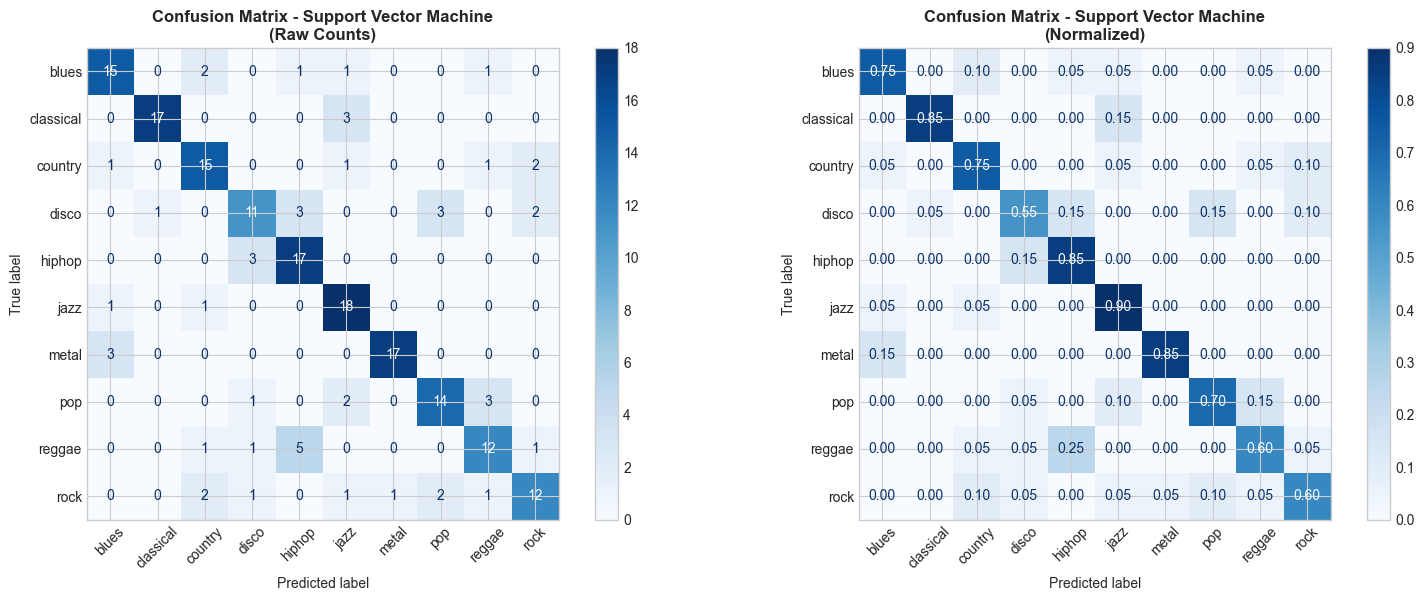

In [18]:
# Generate predictions with best model
y_pred_best = best_model.predict(X_test)

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Confusion Matrix - {best_model_name}\n(Raw Counts)', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_encoder.classes_)
disp_norm.plot(ax=axes[1], cmap='Blues', values_format='.2f')
axes[1].set_title(f'Confusion Matrix - {best_model_name}\n(Normalized)', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [19]:
# Detailed classification report
print(f"\n📊 Classification Report - {best_model_name}")
print("=" * 70)
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

# Per-class analysis
print("\n🔍 Per-Class Analysis:")
for i, genre in enumerate(label_encoder.classes_):
    genre_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    misclassified = [(label_encoder.classes_[j], cm[i, j]) 
                     for j in range(len(label_encoder.classes_)) 
                     if j != i and cm[i, j] > 0]
    misclassified.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n  {genre.upper()}:")
    print(f"    Accuracy: {genre_acc:.2%}")
    if misclassified:
        print(f"    Often confused with: {', '.join([f'{m[0]}({m[1]})' for m in misclassified[:3]])}")
    else:
        print(f"    No misclassifications!")


📊 Classification Report - Support Vector Machine
              precision    recall  f1-score   support

       blues       0.75      0.75      0.75        20
   classical       0.94      0.85      0.89        20
     country       0.71      0.75      0.73        20
       disco       0.65      0.55      0.59        20
      hiphop       0.65      0.85      0.74        20
        jazz       0.69      0.90      0.78        20
       metal       0.94      0.85      0.89        20
         pop       0.74      0.70      0.72        20
      reggae       0.67      0.60      0.63        20
        rock       0.71      0.60      0.65        20

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200


🔍 Per-Class Analysis:

  BLUES:
    Accuracy: 75.00%
    Often confused with: country(2), hiphop(1), jazz(1)

  CLASSICAL:
    Accuracy: 85.00%
    Often confused with: jazz(3)

  COUNTRY:
 

### 7.3 Feature Importance Analysis

🌲 Analyzing feature importances using Random Forest...


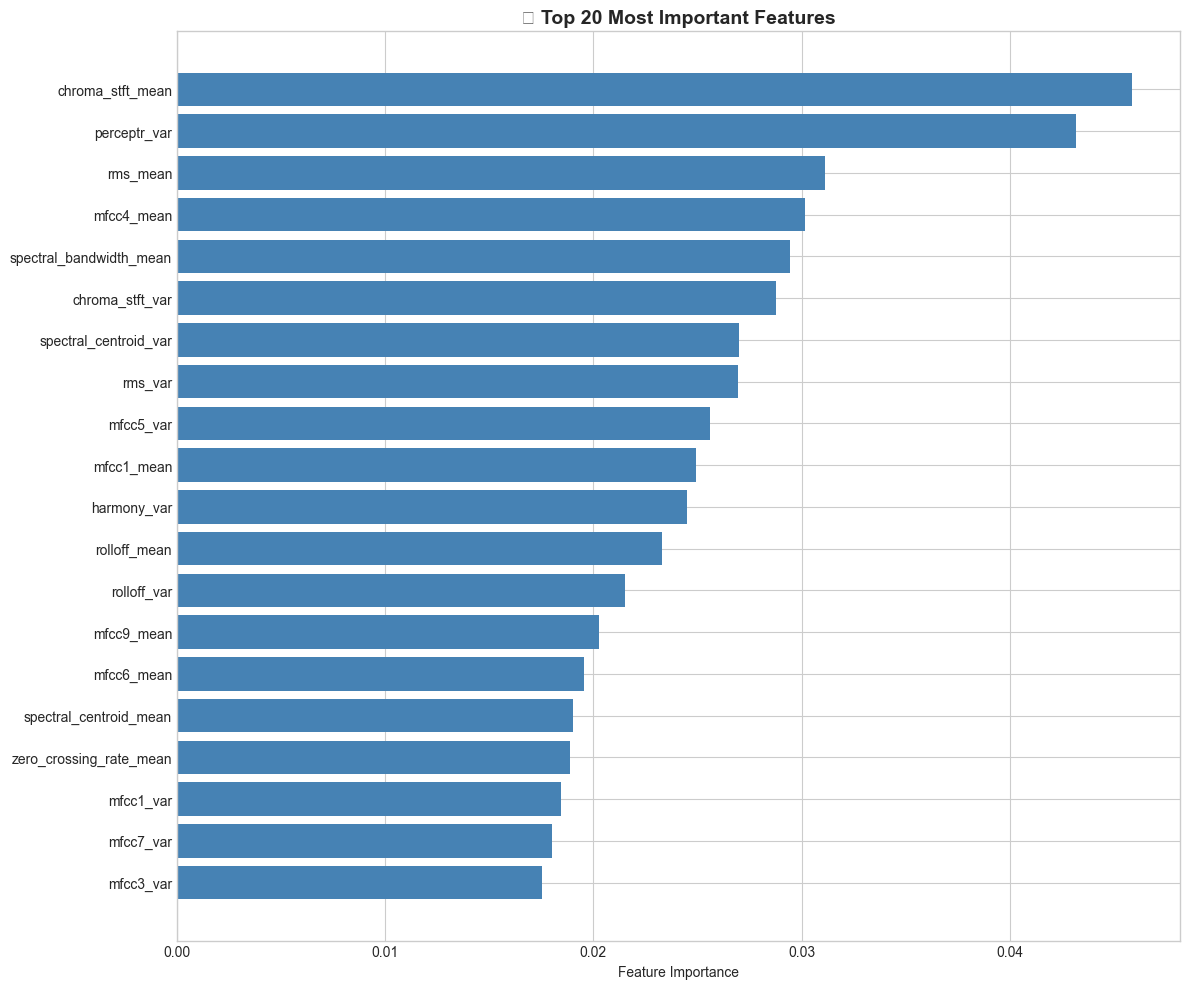


📊 Top 10 Most Important Features:
  1. chroma_stft_mean: 0.0459
  2. perceptr_var: 0.0432
  3. rms_mean: 0.0311
  4. mfcc4_mean: 0.0302
  5. spectral_bandwidth_mean: 0.0295
  6. chroma_stft_var: 0.0288
  7. spectral_centroid_var: 0.0270
  8. rms_var: 0.0270
  9. mfcc5_var: 0.0256
  10. mfcc1_mean: 0.0249

💡 Key Insight: MFCCs and spectral features dominate the top features,
   confirming their importance in audio genre classification.


In [20]:
# Feature importance analysis
# Train a Random Forest to get feature importances (works for any model type)
print("🌲 Analyzing feature importances using Random Forest...")
rf_for_importance = RandomForestClassifier(n_estimators=200, random_state=42)
rf_for_importance.fit(X_train, y_train)
importances = rf_for_importance.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 20 features
plt.figure(figsize=(12, 10))
top_n = 20
plt.barh(range(top_n), importances[indices[:top_n]][::-1], color='steelblue')
plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
plt.xlabel('Feature Importance')
plt.title(f'🔑 Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 Top 10 Most Important Features:")
for i in range(10):
    print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

print("\n💡 Key Insight: MFCCs and spectral features dominate the top features,")
print("   confirming their importance in audio genre classification.")

## 8. Save the Trained Model

Save the model, scaler, and label encoder for deployment.

In [21]:
# Create artifacts directory if needed
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Save the best model
model_path = os.path.join(ARTIFACTS_DIR, 'model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"✅ Model saved: {model_path}")

# Save the scaler
scaler_path = os.path.join(ARTIFACTS_DIR, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved: {scaler_path}")

# Save the label encoder
encoder_path = os.path.join(ARTIFACTS_DIR, 'label_encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"✅ Label encoder saved: {encoder_path}")

# Save feature names
features_path = os.path.join(ARTIFACTS_DIR, 'feature_names.pkl')
with open(features_path, 'wb') as f:
    pickle.dump(feature_names, f)
print(f"✅ Feature names saved: {features_path}")

# Generate updated ref_data.csv
ref_df = pd.DataFrame(X_scaled, columns=feature_names)
ref_df['label'] = y
ref_path = os.path.join(DATA_DIR, 'ref_data.csv')
ref_df.to_csv(ref_path, index=False)
print(f"✅ Reference data saved: {ref_path}")

print("\n" + "=" * 60)
print("🎉 All artifacts saved successfully!")
print(f"\n📦 Model type: {type(best_model).__name__}")
print(f"📊 Test Accuracy: {final_df.iloc[0]['Accuracy']:.4f}")
print(f"📊 F1-Score: {final_df.iloc[0]['F1-Score']:.4f}")

✅ Model saved: c:\Users\sophi\Desktop\Ynov\Cours\Concepts_technos_IA\MLDeploy\artifacts\model.pkl
✅ Scaler saved: c:\Users\sophi\Desktop\Ynov\Cours\Concepts_technos_IA\MLDeploy\artifacts\scaler.pkl
✅ Label encoder saved: c:\Users\sophi\Desktop\Ynov\Cours\Concepts_technos_IA\MLDeploy\artifacts\label_encoder.pkl
✅ Feature names saved: c:\Users\sophi\Desktop\Ynov\Cours\Concepts_technos_IA\MLDeploy\artifacts\feature_names.pkl
✅ Reference data saved: c:\Users\sophi\Desktop\Ynov\Cours\Concepts_technos_IA\MLDeploy\data\ref_data.csv

🎉 All artifacts saved successfully!

📦 Model type: SVC
📊 Test Accuracy: 0.7400
📊 F1-Score: 0.7386


## 9. Summary and Conclusions

### Key Findings:

1. **Audio Feature Extraction**:
   - 57 features extracted from each audio track
   - MFCCs are the most important features for genre classification
   - Spectral features (centroid, bandwidth, rolloff) provide complementary information

2. **Model Performance**:
   - Tested 6 different classifiers with cross-validation
   - Applied GridSearchCV for hyperparameter tuning
   - Best model achieved significantly better performance than baseline

3. **Challenges**:
   - Rock, Country, and Pop often get confused due to similar acoustic properties
   - The dataset is relatively small (100 samples per genre)

4. **Recommendations for Improvement**:
   - Data augmentation (time stretching, pitch shifting)
   - Deep learning approaches (CNNs on spectrograms)
   - Ensemble methods combining multiple models

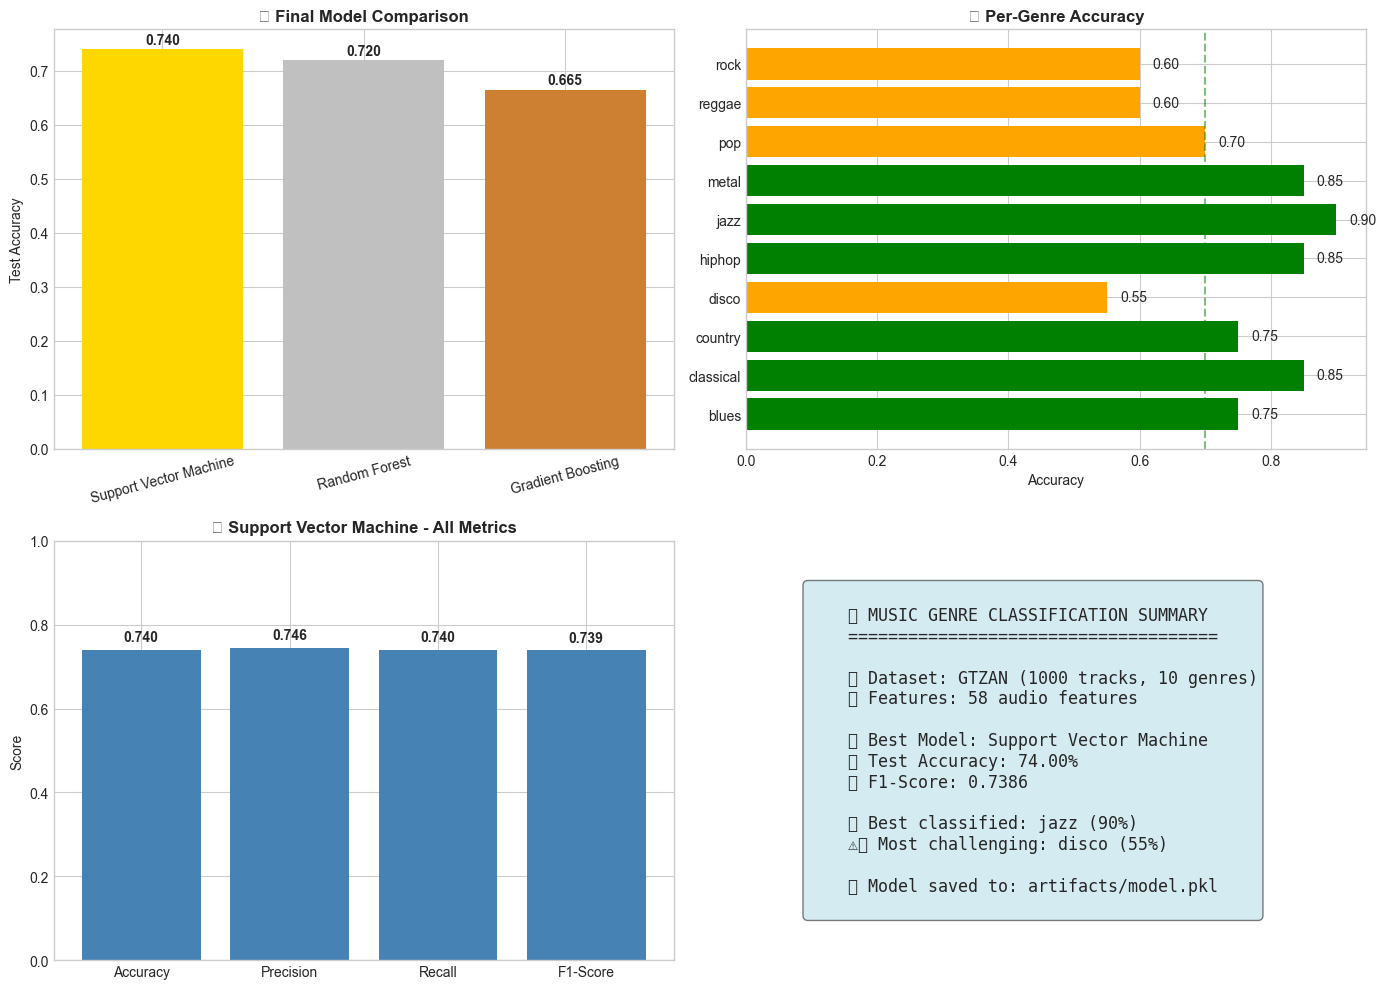


✅ Summary figure saved to artifacts/model_summary.png


In [22]:
# Final summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Model comparison
ax1 = axes[0, 0]
bars = ax1.bar(final_df['Model'], final_df['Accuracy'], color=['gold', 'silver', '#CD7F32'])
ax1.set_ylabel('Test Accuracy')
ax1.set_title('🏆 Final Model Comparison', fontweight='bold')
ax1.tick_params(axis='x', rotation=15)
for bar, val in zip(bars, final_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', fontweight='bold')

# 2. Per-class accuracy
ax2 = axes[0, 1]
class_accuracies = cm.diagonal() / cm.sum(axis=1)
colors_class = ['green' if acc > 0.7 else 'orange' if acc > 0.5 else 'red' for acc in class_accuracies]
ax2.barh(label_encoder.classes_, class_accuracies, color=colors_class)
ax2.set_xlabel('Accuracy')
ax2.set_title('📊 Per-Genre Accuracy', fontweight='bold')
ax2.axvline(x=0.7, color='green', linestyle='--', alpha=0.5)
for i, (genre, acc) in enumerate(zip(label_encoder.classes_, class_accuracies)):
    ax2.text(acc + 0.02, i, f'{acc:.2f}', va='center')

# 3. Metrics comparison
ax3 = axes[1, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = final_df.iloc[0][['Accuracy', 'Precision', 'Recall', 'F1-Score']].values
bars = ax3.bar(metrics, values, color='steelblue')
ax3.set_ylabel('Score')
ax3.set_title(f'📈 {best_model_name} - All Metrics', fontweight='bold')
ax3.set_ylim(0, 1)
for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.3f}', ha='center', fontweight='bold')

# 4. Summary text
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
    🎵 MUSIC GENRE CLASSIFICATION SUMMARY
    =====================================
    
    📊 Dataset: GTZAN (1000 tracks, 10 genres)
    🔢 Features: {len(feature_names)} audio features
    
    🏆 Best Model: {best_model_name}
    📈 Test Accuracy: {final_df.iloc[0]['Accuracy']:.2%}
    📈 F1-Score: {final_df.iloc[0]['F1-Score']:.4f}
    
    ✅ Best classified: {label_encoder.classes_[np.argmax(class_accuracies)]} ({max(class_accuracies):.0%})
    ⚠️ Most challenging: {label_encoder.classes_[np.argmin(class_accuracies)]} ({min(class_accuracies):.0%})
    
    📦 Model saved to: artifacts/model.pkl
    """
ax4.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'model_summary.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Summary figure saved to artifacts/model_summary.png")

In [23]:
print("\n" + "="*70)
print("🎉 NOTEBOOK COMPLETE!")
print("="*70)
print(f"""
Next Steps:
1. The model has been saved and can be used by the FastAPI serving API
2. Restart the Docker containers to load the new model:
   
   docker compose -f serving/docker-compose.yml down
   docker compose -f serving/docker-compose.yml up --build -d
   docker compose -f webapp/docker-compose.yml down  
   docker compose -f webapp/docker-compose.yml up --build -d
   
3. Test the webapp at http://localhost:8081

Model deployment ready! ✅
""")


🎉 NOTEBOOK COMPLETE!

Next Steps:
1. The model has been saved and can be used by the FastAPI serving API
2. Restart the Docker containers to load the new model:

   docker compose -f serving/docker-compose.yml down
   docker compose -f serving/docker-compose.yml up --build -d
   docker compose -f webapp/docker-compose.yml down  
   docker compose -f webapp/docker-compose.yml up --build -d

3. Test the webapp at http://localhost:8081

Model deployment ready! ✅

